In [91]:
from datetime import datetime
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import requests
import pandas as pd
from pprint import pprint
import seaborn as sns
import time

from country import country_to_continent

### Upload each loan page of the Kiva snapshot from 2016/12/28

In [2]:
filenum = 1
with open('kiva_ds_json_2016_12_28/lenders/%s.json' % filenum) as data_file:    
        data = json.load(data_file)

In [3]:
# Return the length of a given array, or zero if the array object is null
def get_length(x):
    if x is None:
        return 0
    else:
        return len(x)
    
def upload_loan_page(filenum):
    with open('kiva_ds_json_2016_12_28/loans_lenders/%s.json' % filenum) as data_file:    
        data = json.load(data_file)
    num_lenders_per_loan = [[k['id'], get_length(k['lender_ids']), k['lender_ids']] for k in data['loans_lenders']]
    df = pd.DataFrame(num_lenders_per_loan, columns=['loan_id', 'num_public_lenders', 'lenders'])
    return df

In [4]:
# From the 2016/12/28 snapshot there are 
# - 1189 pages of loans and 
# - 2101 pages of public lenders
loans = pd.DataFrame(columns=['loan_id', 'num_public_lenders', 'lenders'])
for i in range(1, 11):
    loans = pd.concat([loans, upload_loan_page(i)])
    
loans.index = range(len(loans.index))
loans['loan_id'] = loans.loan_id.apply(lambda x: int(x))

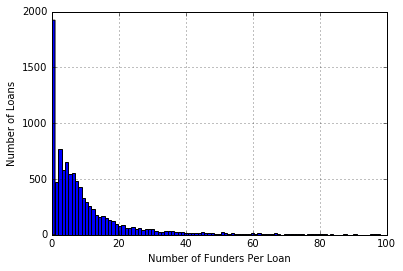

In [5]:
max_num = 100
loans[loans.num_public_lenders < max_num].num_public_lenders.hist(bins=max_num)
plt.xlim(0, max_num)
plt.xlabel('Number of Funders Per Loan')
plt.ylabel("Number of Loans")

In [6]:
loans.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999],
           dtype='int64', length=10000)


### Get loan details for every loan in the snapshot

In [204]:
load_saved_data = True

In [224]:
if load_saved_data:
    loans = pd.DataFrame.from_csv('loans_10k.csv')
else:
    # Rate limit is 60 requests per minute (1/s) so instead of getting info for each loan through
    # its own API call, bundle loans up into groups of 50 (the max number allowed in a single call)
    # and grab a max of 50 * 60 = 3e3 loans in a minute.
    max_index = max(loans.index)
    # max_index = 3000
    loan_details = {}
    count = 0
    for i in range(0, max_index + 1, 50):
        if i%500 == 0:
            print(i)

        # Construct the url to get details for 50 loans from the API
        url = 'http://api.kivaws.org/v1/loans/'
        for loan_id in loans.loan_id[i: i + 50]:
            url += '%s,' % loan_id
        url = url[:-1] + '.json'

        # Get the details for the 50 loans
        response = requests.get(url)
        loan = eval(response.content.replace('false', 'False').replace('true', 'True'))

        # Put the details into a dictionary with each loan id as a key
        for n in range(len(loan['loans'])):
            loan_id = loan['loans'][n]['id']
            loan_details[loan_id] = loan['loans'][n]

        # Sleep for 1 sec to not overload the API
        time.sleep(1)

### Put the useful values into a dataframe so we can start to cluster them.

In [223]:
def get_percent_female_borrowers(x):
    borrower_is_F = [k['gender'] == 'F' for k in loan_details[x].get('borrowers', [])]
    percent_F = sum(borrower_is_F) * 100.0 /len(borrower_is_F)
    return percent_F

def get_num_pictured(x):
    borrower_pictured = [k['pictured'] for k in loan_details[x].get('borrowers', [])]
    return sum(borrower_pictured)

def get_loan_desc_en(x):
    return loan_details[x]['description']['texts'].get('en')

def get_loan_percent_funded(x):
    return loan_details[x].get('funded_amount') * 100.0 / loan_details[x].get('loan_amount')

def get_loan_amount_unfunded(x):
    return loan_details[x].get('loan_amount') - loan_details[x].get('funded_amount')

def get_date(datename, x):
    return datetime.strptime(loan_details[x].get(datename)[:-1], "%Y-%m-%dT%H:%M:%S")

def get_tags(x):
    tags = [eval(k.get('name').replace('#', '')) for k in loan_details[x].get('tags', [])]
    
def eval_string(x):
    if type(x) == str:
        return eval(x)
    else:
        return []


In [225]:
if load_saved_data:
    print('Variables converted')
else:
    print('Convert data from json to dataframe')
    # Lender info
    loans['num_total_lenders'] = loans.loan_id.apply(lambda x: loan_details[x].get('lender_count'))

    # Borrower specifics
    loans['borrowers_total'] = loans.loan_id.apply(lambda x: len(loan_details[x].get('borrowers')))
    loans['borrowers_pct_female'] = loans.loan_id.apply(lambda x: get_percent_female_borrowers(x))
    loans['borrowers_num_pictured'] = loans.loan_id.apply(lambda x: get_num_pictured(x))

    # Location specifics
    # TODO: GDP
    loans['country'] = loans.loan_id.apply(lambda x: loan_details[x]['location'].get('country'))
    loans['country_code'] = loans.loan_id.apply(lambda x: loan_details[x]['location'].get('country_code'))
    loans['continent'] = loans.country.apply(lambda x: country_to_continent.get(x, 'Unknown'))
    loans['town'] = loans.loan_id.apply(lambda x: loan_details[x]['location'].get('town'))
    loans['town_type'] = loans.loan_id.apply(lambda x: loan_details[x]['location']['geo'].get('level'))
    loans['lat_long'] = loans.loan_id.apply(lambda x: loan_details[x]['location']['geo'].get('pairs'))
    loans['latitude'] = loans.lat_long.apply(lambda x: x.split(' ')[0])
    loans['longitude'] = loans.lat_long.apply(lambda x: x.split(' ')[1])
    
    # Funding specifics
    loans['loan_amount'] = loans.loan_id.apply(lambda x: loan_details[x].get('loan_amount'))
    loans['loan_amount_funded'] = loans.loan_id.apply(lambda x: loan_details[x].get('funded_amount'))
    loans['loan_pct_funded'] = loans.loan_id.apply(lambda x: get_loan_percent_funded(x))
    loans['loan_amount_unfunded'] = loans.loan_id.apply(lambda x: get_loan_amount_unfunded(x))
    loans['loan_status'] = loans.loan_id.apply(lambda x: loan_details[x].get('status'))

    # Use specifics
    loans['sector'] = loans.loan_id.apply(lambda x: loan_details[x].get('sector'))
    loans['activity'] = loans.loan_id.apply(lambda x: loan_details[x].get('activity'))
    loans['loan_desc_en'] = loans.loan_id.apply(lambda x: get_loan_desc_en(x))
    loans['use'] = loans.loan_id.apply(lambda x: loan_details[x].get('use'))

    # Dates
    loans['posted_date'] = loans.loan_id.apply(lambda x: get_date('posted_date', x))
    loans['expiration_date'] = loans.loan_id.apply(lambda x: get_date('planned_expiration_date', x))

    # Tags & Themes
    loans['tags'] = loans.loan_id.apply(lambda x: get_tags(x))
    loans['themes'] = loans.loan_id.apply(lambda x: loan_details[x].get('themes'))
    
    # Save the ouput to a file so we don't have to grab it from the API every time
    loans.to_csv('loans_10k.csv')
    
    print('Convert Strings to lists')
    
# Whether loading or not, change columns with strings of lists to an actual list
loans['lenders'] = loans.lenders.apply(lambda x: eval_string(x))
loans['tags'] = loans.tags.apply(lambda x: eval_string(x))
loans['themes'] = loans.themes.apply(lambda x: eval_string(x))


Convert Strings to lists


In [233]:
# Let's look only at loans with public lenders.
loans = loans[loans.num_public_lenders > 0]
loans.index = range(len(loans.index))


In [235]:
loans.groupby(['continent']).count()

,loan_id,num_public_lenders,lenders,num_total_lenders,borrowers_total,borrowers_pct_female,borrowers_num_pictured,country,country_code,town,...,loan_amount_unfunded,loan_status,sector,activity,loan_desc_en,use,posted_date,expiration_date,tags,themes
continent,,,,,,,,,,,,,,,,,,,,,
Africa,2038,2038,2038,2038,2038,2038,2038,2038,2038,1898,...,2038,2038,2038,2038,2035,2035,2038,2038,2038,2038
Asia,3549,3549,3549,3549,3549,3549,3549,3549,3549,3503,...,3549,3549,3549,3549,3548,3548,3549,3549,3549,3549
Europe,193,193,193,193,193,193,193,193,193,192,...,193,193,193,193,193,193,193,193,193,193
North_America,793,793,793,793,793,793,793,793,793,650,...,793,793,793,793,792,792,793,793,793,793
Oceania,264,264,264,264,264,264,264,264,264,264,...,264,264,264,264,264,264,264,264,264,264
South_America,1054,1054,1054,1054,1054,1054,1054,1054,1054,1051,...,1054,1054,1054,1054,1053,1053,1054,1054,1054,1054
Unknown,186,186,186,186,186,186,186,186,186,177,...,186,186,186,186,186,186,186,186,186,186


In [236]:
loans.groupby(['sector']).count()

,loan_id,num_public_lenders,lenders,num_total_lenders,borrowers_total,borrowers_pct_female,borrowers_num_pictured,country,country_code,continent,...,loan_pct_funded,loan_amount_unfunded,loan_status,activity,loan_desc_en,use,posted_date,expiration_date,tags,themes
sector,,,,,,,,,,,,,,,,,,,,,
Agriculture,2200,2200,2200,2200,2200,2200,2200,2200,2200,2200,...,2200,2200,2200,2200,2198,2198,2200,2200,2200,2200
Arts,199,199,199,199,199,199,199,199,199,199,...,199,199,199,199,199,199,199,199,199,199
Clothing,348,348,348,348,348,348,348,348,348,348,...,348,348,348,348,348,348,348,348,348,348
Construction,66,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,66,66,66
Education,386,386,386,386,386,386,386,386,386,386,...,386,386,386,386,385,385,386,386,386,386
Entertainment,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
Food,1582,1582,1582,1582,1582,1582,1582,1582,1582,1582,...,1582,1582,1582,1582,1580,1580,1582,1582,1582,1582
Health,188,188,188,188,188,188,188,188,188,188,...,188,188,188,188,188,188,188,188,188,188
Housing,400,400,400,400,400,400,400,400,400,400,...,400,400,400,400,400,400,400,400,400,400


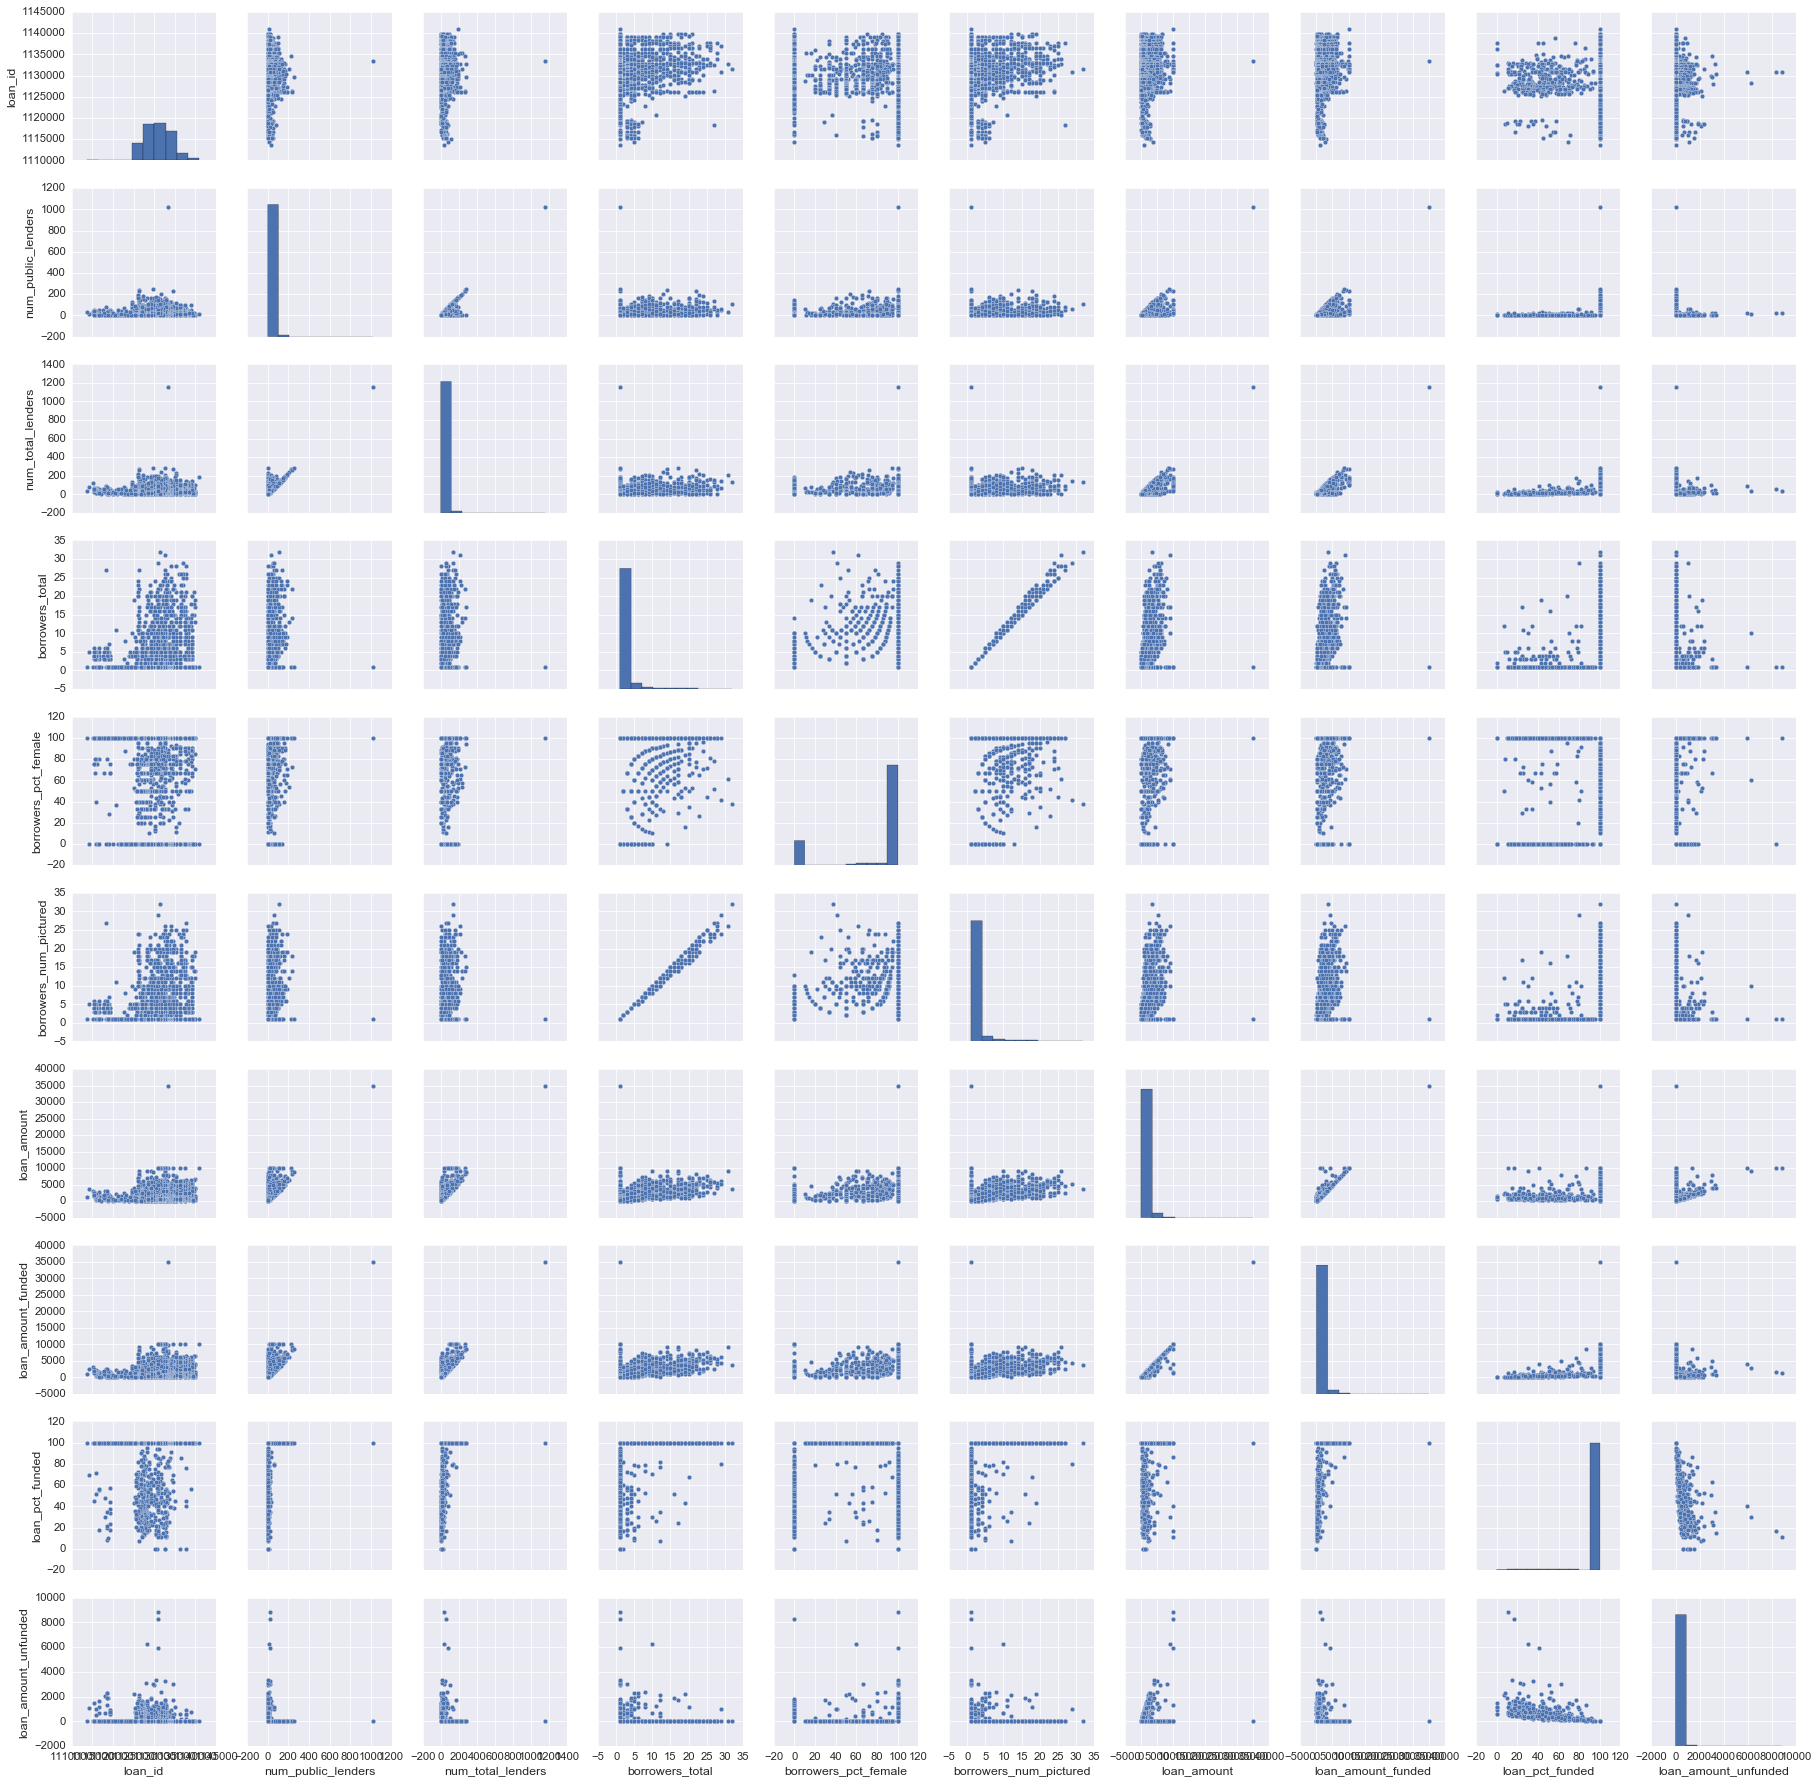

In [42]:
sns.set_context("paper", font_scale=1.4)
sns.pairplot(loans);

## Get lender information

In [237]:
# # Get a table of users that contributed to these loans, and ping the API to see a list of all loans this 
# # user contributed to
# lender_list = set()
# for lenders in loans.lenders.values:
#     lender_list = lender_list | set(lenders)

In [ ]:
def make_loan_specific_table(input_df, column_to_transform_to_rows, column_name):
    # Make a separate dataframe with one row for each unique variable/loan pair
    df = pd.DataFrame(input_df.apply(lambda x: pd.Series(x[column_to_transform_to_rows]),axis=1).stack().reset_index(level=1, drop=True))

    df.columns = [column_name]
    df['loan_index'] = df.index
    df['loan_id'] = df.loan_index.apply(lambda x: loans.loan_id[x])
    df.drop('loan_index', axis=1, inplace=True)

    return df

# Make a separate dataframe with one row for each unique lender/loan pair
lenders = make_loan_specific_table(loans, 'lenders', 'lender_id')

# Randomly shuffle the lender_id's to make a permuted lender_id variable that we can test against.
# (This will be our equivalent of "random".)
lenders['lender_id_permuted'] = np.random.permutation(lenders.lender_id.tolist())

In [ ]:
# Make separate tables for tags and themes so they're in a more usable format.
tags = make_loan_specific_table(loans, 'tags', 'tag')
themes = make_loan_specific_table(loans, 'themes', 'theme')

In [251]:
# And now that we have lenders, tags, and themes in separate tables, drop them from the loans table
# to make it more manageable.
loans.drop('lenders', 1, inplace=True)
loans.drop('tags', 1, inplace=True)
loans.drop('themes', 1, inplace=True)

## Put data in SQL for easier manipulation

In [255]:
insert_into_db = True

In [261]:
# It looks like to do data manipulation that will scale, we should put things in SQL
# MAKE SURE TO LAUNCH POSTGRES LOCALLY!
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2


dbname = 'kiva_data'
username = 'brianna'

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print engine.url

## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username)

if insert_into_db:
    ## insert tables into database 
    print('Insert loans table')
    loans.to_sql('loans', engine, if_exists='replace')
    print('Insert lenders table')
    lenders.to_sql('lenders', engine, if_exists='replace')
    print('Insert tags table')
    tags.to_sql('tags', engine, if_exists='replace')
    print('Insert themes table')
    themes.to_sql('themes', engine, if_exists='replace')


postgres://brianna@localhost/kiva_data
True
Insert loans table
Insert lenders table
Insert tags table
Insert themes table


# Do users tend to have consistent preferences?
### Get similarity measure for loans for each lender.

If we had ratings for each loan, we could do something like a straightforward cosine similarity measure between items given the ratings from a large number of people.  However, since here there are no ratings and most users only take out 1-2 loans, we'll have to be more creative to figure out similarity between loans.

To see which features are most important for similarity, let's use the following similarity definitions:
Factors: # distinct values / # total loans
Continuous Variables: standard error from mean

There are some nuances in similarity calculation for factors here since the measure depends on
    - number of distinct values in the group of loans for a specific factor
    - number of total possible values in that factor
    - number of loans that a user has taken
For example, if I look at 2 different users:
    - User A has taken 6 loans and each loan was on a different continent
    - User B has taken 50 loans and 45 of them were from Asia but 5 of them were from each of the other continents
Both users have taken loans in 6 of 6 continents, but clearly User B has more similarity among their continent preference.

To deal with this, we'll calculate similarity for the real group of users, and similarity for a "fake" group.  (Ie. one where the lender_id labels are randomly permuted) and see how different they are.  We'll say that features where loans have more similarity if they have been associated with a single user then picked at random are more "important", and we'll use the important features to construct our recommender system.

In [325]:
# Leave out things like loan description and lat/long for now, though they could be interesting to explore later.
factors = ['country', 
           'continent',
           'town_type',
           'sector',
           'tags',
           'themes'
           ]
continuous_vars = ['num_total_lenders',
                   'borrowers_total',
                   'borrowers_pct_female',
                   'loan_amount',
                   'loan_amount_funded',
                   'loan_pct_funded',
                   'loan_amount_unfunded',
                   
                  ]

## Similarity for Variables which are Factors

In [320]:
# For factors (ex. continent) we'll define this as the number of unique values
# divided by the total number of loans
get_detail_similarity = """
SELECT {0},
       COUNT(DISTINCT(country))/COUNT(*)::FLOAT as fraction_distinct_country,
       COUNT(DISTINCT(continent))/COUNT(*)::FLOAT as fraction_distinct_continent,
       COUNT(DISTINCT(town_type))/COUNT(*)::FLOAT as fraction_distinct_town_type,
       COUNT(DISTINCT(sector))/COUNT(*)::FLOAT as fraction_distinct_sector,
       COUNT(*) as total_loans
FROM loans 
JOIN lenders
ON loans.loan_id = lenders.loan_id
GROUP BY {0};
"""
sim_details = pd.read_sql_query(get_detail_similarity.format('lender_id'),con)
sim_details_perm = pd.read_sql_query(get_detail_similarity.format('lender_id_permuted'),con)

# For tags and themes we'll define this as the number of unique values divided by the total number 
# of tags/themes in loans for that lender
get_tag_similarity = """
SELECT {0},
       COUNT(DISTINCT(tag))/COUNT(*)::FLOAT as fraction_distinct_tags,
       COUNT(*) as total_tags
FROM loans, lenders, tags
WHERE loans.loan_id = lenders.loan_id AND loans.loan_id = tags.loan_id
GROUP BY {0};
"""
sim_tags = pd.read_sql_query(get_tag_similarity.format('lender_id'),con)
sim_tags_perm = pd.read_sql_query(get_tag_similarity.format('lender_id_permuted'),con)

get_theme_similarity = """
SELECT {0},
       COUNT(DISTINCT(theme))/COUNT(*)::FLOAT as fraction_distinct_themes,
       COUNT(*) as total_themes
FROM loans, lenders, themes
WHERE loans.loan_id = lenders.loan_id AND loans.loan_id = themes.loan_id
GROUP BY {0};
"""
sim_themes = pd.read_sql_query(get_theme_similarity.format('lender_id'),con)
sim_themes_perm = pd.read_sql_query(get_theme_similarity.format('lender_id_permuted'),con)

In [334]:
sim_factors = sim_details.merge(sim_tags, on='lender_id', how='outer')
sim_factors = sim_factors.merge(sim_themes, on='lender_id', how='outer')

sim_factors_perm = sim_details_perm.merge(sim_tags_perm, on='lender_id_permuted', how='outer')
sim_factors_perm = sim_factors_perm.merge(sim_themes_perm, on='lender_id_permuted', how='outer')

In [336]:
# Set a max loans value since there's a really large tail on this
min_loans = 2
max_loans = 20

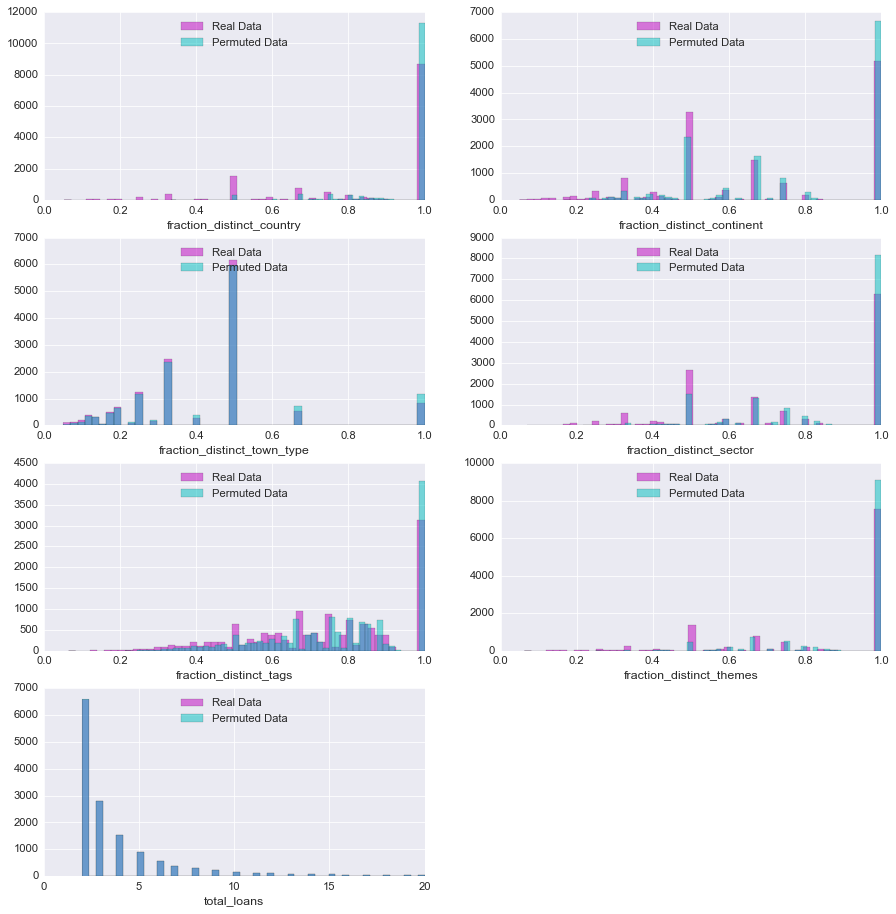

In [350]:
# Only look at lenders with loans between specified min_loan and max_loan
sim_factors = sim_factors[sim_factors.total_loans.between(min_loans, max_loans)]
sim_factors_perm = sim_factors_perm[sim_factors_perm.total_loans.between(min_loans, max_loans)]

# Plot all of these variables
variables = ['fraction_distinct_%s' % f for f in factors]
variables.append('total_loans')

i = 1
plt.figure(figsize=(15,20))
plt.gcf().subplots_adjust(bottom=0.3)
for v in variables:
    plt.subplot(4, 2, i)
    i += 1
    plt.hist(sim_factors[v].dropna(), bins=50, color='m', alpha=.5, label='Real Data')
    plt.hist(sim_factors_perm[v].dropna(), bins=50, color='c', alpha=.5, label='Permuted Data')
    plt.xlabel(v)
    plt.legend(loc="upper center")
plt.show()


As we would expect, real users have fewer distinct entries in their loans (ie. their loans tend to go towards the same type of factor more often) for country, continent, and sector.  

The fact that the distributions for real and permuted data almost completely overlap for "fraction_distinct_town_type" implies that don't appear to care about the town type when they offer a loan.

The distribution of total loans at the end is just a sanity check.  The two distributions should totally overlap (and they do) since the lender list was just permuted, so each lenders should still have the same amount of loans after the permutation (just different ones than that lender actually offered.)

# Use K-S test to see which distributions are the most different!

## Similarity for Continuous Variables

In [303]:
# For factors (ex. continent) we'll define this as the number of unique values
# divided by the total number of loans
get_continuous_var_similarity = """
SELECT {0},
       STDDEV(num_total_lenders) as std_num_total_lenders,
       STDDEV(borrowers_total) as std_borrowers_total,
       STDDEV(borrowers_pct_female) as std_borrowers_pct_female,
       STDDEV(loan_amount) as std_loan_amount,
       STDDEV(loan_amount_funded) as std_loan_amount_funded,
       STDDEV(loan_pct_funded) as std_loan_pct_funded,
       STDDEV(loan_amount_unfunded) as std_loan_amount_unfunded,
       COUNT(*) as total_loans
FROM loans 
JOIN lenders
ON loans.loan_id = lenders.loan_id
GROUP BY {0};
"""
sim_cont = pd.read_sql_query(get_continuous_var_similarity.format('lender_id'),con)
sim_cont_perm = pd.read_sql_query(get_continuous_var_similarity.format('lender_id_permuted'),con)

sim_cont.head()

,lender_id,std_num_total_lenders,std_borrowers_total,std_borrowers_pct_female,std_loan_amount,std_loan_amount_funded,std_loan_pct_funded,std_loan_amount_unfunded,total_loans
0,07272010,622.647841,0.000000,57.735027,19072.236584,19072.236584,0,0,3
1,100ofhumanity1199,16.263456,3.535534,11.785113,388.908730,388.908730,0,0,2
6,2015unisgrade83198,19.739976,1.500000,0.000000,531.507291,531.507291,0,0,4
8,369,26.274195,0.000000,0.000000,571.365324,571.365324,0,0,3
9,3Katz,48.048587,7.164728,10.544585,1545.288538,1545.288538,0,0,4


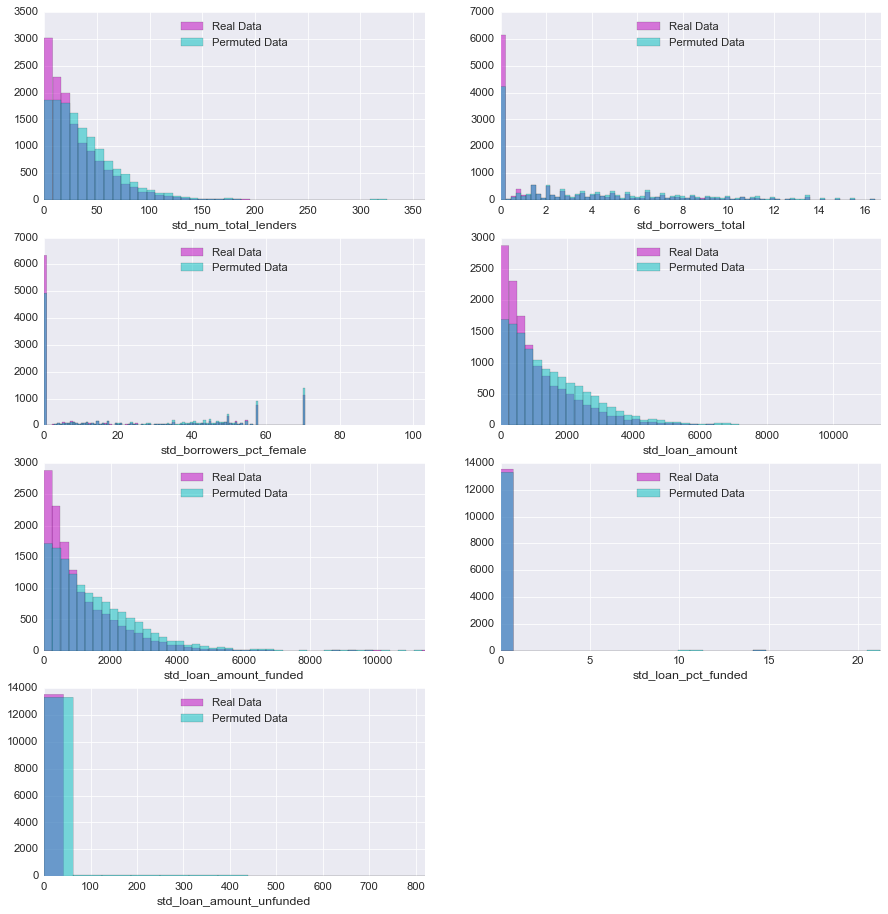

In [351]:
# Only look at lenders with loans between specified min_loan and max_loan
sim_cont = sim_cont[sim_cont.total_loans.between(min_loans, max_loans)]
sim_cont_perm = sim_cont_perm[sim_cont_perm.total_loans.between(min_loans, max_loans)]

# Plot all of these variables
variables = ['std_%s' % c for c in continuous_vars]

i = 1
plt.figure(figsize=(15,20))
plt.gcf().subplots_adjust(bottom=0.3)
for v in variables:
    plt.subplot(4, 2, i)
    i += 1
    plt.hist(sim_cont[v], bins=100, color='m', alpha=.5, label='Real Data')
    plt.hist(sim_cont_perm[v], bins=100, color='c', alpha=.5, label='Permuted Data')
    plt.xlabel(v)
    mean_plus_3sd = np.mean(sim_cont_perm[v]) + 3*np.std(sim_cont_perm[v])
    plt.xlim(0, mean_plus_3sd)
    plt.legend(loc="upper center")

plt.show()


From these plots it looks like users offer loans that are more similar in:
    - number of lenders
    - number of borrowers
    - fraction of females (maybe)
    - loan amount
It appears that they also care about the amount of loan that's been funded, but the fact that there's no difference in similarity in the amount that's unfunded makes me think that is most likely just a side effect of the fact that that the amount funded is highly correlated with the total loan amount.

It looks like there's not enough variation in the % of each loan that's funded or unfunded to tell if there's any effect in those.